<div style="width: 100%; max-width: 100%; background-color: #fefefe; border: 1px solid #333; border-radius: 10px; padding: 20px; font-family: Arial, sans-serif; box-sizing: border-box;">
  <h3 style="color: #2c3e50; text-align: center;">Other Model (Additional Content)</h2>
  
  <p style="color: #34495e; line-height: 1.6;">
    Initially planned to use three models, including random forest regression, but underestimated the workload. Some progress was made, yielding useful insights, which were included as additional content.

  <p style="color: #34495e; line-height: 1.6;">
    This section compares the training results of linear regression and random forest regression. Due to my limited machine learning background, the focus was on PCA prior to model training, serving as a supplement on matrix dimensionality reduction.

  <p style="color: #34495e; line-height: 1.6;">
    Unlike AR and VAR models, I did not train models for each country individually. Instead, data from all countries was combined and divided into two groups: Per Capita Data and Total Data. These datasets have varying levels of complexity, allowing for clear observation of different machine learning models’ performance.

  <p style="color: #34495e; line-height: 1.6;">
    The random forest regression model performed well on both datasets, while the linear regression model struggled with Per Capita Data, producing less satisfactory results.
  </p>
  
</div>

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# 1. Load data
url = 'data_imputation_full.csv'
data_full = pd.read_csv(url, index_col=[0, 1])

In [13]:
# 2. Define variables for two models
gdp_model_per_capita_vars = [
    'Economics: GDP',
    'Electricity: Distribution Losses Per Capita',
    'Electricity: Exports Per Capita',
    'Electricity: Imports Per Capita',
    'Electricity: Installed Capacity Per Capita',
    'Electricity: Net Consumption Per Capita',
    'Electricity: Net Generation Per Capita',
    'Electricity: Net Imports Per Capita',
    'Population: Area (km²)',
    'Population: Density', 
    'Population: Growth Rate',
    'Population: Percentage', 
    'Population: Population'
]

gdp_model_total_vars = [
    'Economics: GDP',
    'Electricity: Distribution Losses',
    'Electricity: Exports',
    'Electricity: Imports',
    'Electricity: Installed Capacity',
    'Electricity: Net Consumption',
    'Electricity: Net Generation',
    'Electricity: Net Imports',
    'Population: Area (km²)',
    'Population: Density', 
    'Population: Growth Rate',
    'Population: Percentage', 
    'Population: Population'
]

gdp_model_per_capita_data = data_full.loc[data_full.index.get_level_values(1).isin(gdp_model_per_capita_vars)]
gdp_model_total_data = data_full.loc[data_full.index.get_level_values(1).isin(gdp_model_total_vars)]

# Reshape data
gdp_model_per_capita_data = gdp_model_per_capita_data.stack().reset_index()
gdp_model_per_capita_data.columns = ['Country', 'Variable', 'Year', 'Value']
gdp_model_per_capita_data = gdp_model_per_capita_data.pivot_table(index=['Country', 'Year'], columns='Variable', values='Value').reset_index()

gdp_model_total_data = gdp_model_total_data.stack().reset_index()
gdp_model_total_data.columns = ['Country', 'Variable', 'Year', 'Value']
gdp_model_total_data = gdp_model_total_data.pivot_table(index=['Country', 'Year'], columns='Variable', values='Value').reset_index()

# Standardize the data
features_per_capita = gdp_model_per_capita_data.columns.difference(['Country', 'Year'])
features_total = gdp_model_total_data.columns.difference(['Country', 'Year'])

scaler = StandardScaler()
gdp_model_per_capita_scaled = scaler.fit_transform(gdp_model_per_capita_data[features_per_capita])
gdp_model_total_scaled = scaler.fit_transform(gdp_model_total_data[features_total])

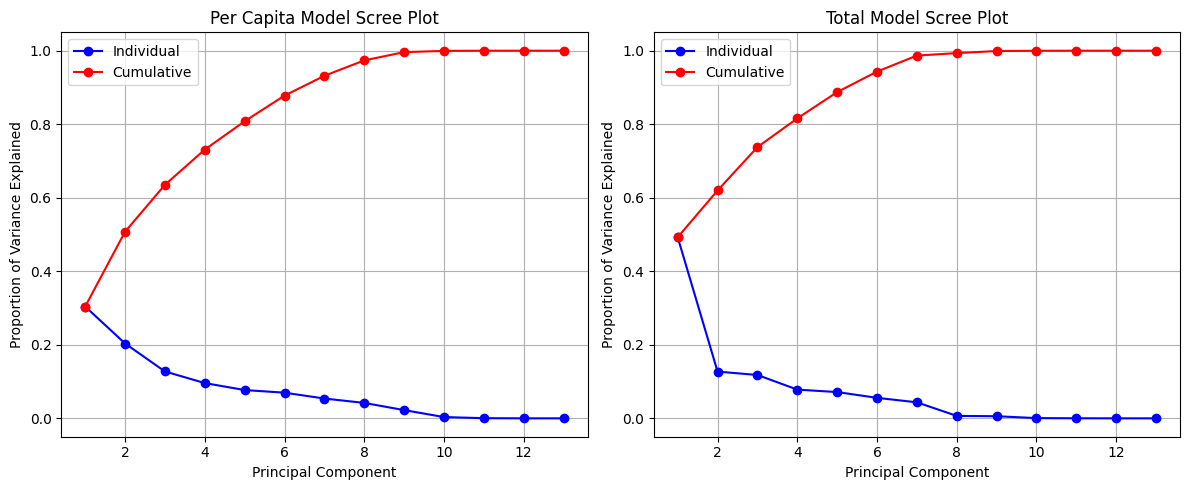

In [14]:
# 5. Perform PCA
pca_gdp_model_per_capita = PCA()
principal_components_per_capita = pca_gdp_model_per_capita.fit_transform(gdp_model_per_capita_scaled)

pca_gdp_model_per_capita_df = pd.DataFrame(data=principal_components_per_capita,
                                 columns=[f'PC{i+1}' for i in range(principal_components_per_capita.shape[1])])


pca_gdp_model_total = PCA()
principal_components_total = pca_gdp_model_total.fit_transform(gdp_model_total_scaled)

pca_gdp_model_total_df = pd.DataFrame(data=principal_components_total,
                            columns=[f'PC{i+1}' for i in range(principal_components_total.shape[1])])

# 6. Visualize cumulative explained variance
# Per Capita Model Scree Plot
explained_variance_ratio_pc = pca_gdp_model_per_capita.explained_variance_ratio_
cumulative_variance_ratio_pc = np.cumsum(explained_variance_ratio_pc)

plt.figure(figsize=(12, 5))

# Subplot for Per Capita Model
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio_pc) + 1), explained_variance_ratio_pc, 'bo-', label='Individual')
plt.plot(range(1, len(cumulative_variance_ratio_pc) + 1), cumulative_variance_ratio_pc, 'ro-', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Per Capita Model Scree Plot')
plt.legend()
plt.grid(True)

# Total Model Scree Plot
explained_variance_ratio_total = pca_gdp_model_total.explained_variance_ratio_
cumulative_variance_ratio_total = np.cumsum(explained_variance_ratio_total)

# Subplot for Total Model
plt.subplot(1, 2, 2)
plt.plot(range(1, len(explained_variance_ratio_total) + 1), explained_variance_ratio_total, 'bo-', label='Individual')
plt.plot(range(1, len(cumulative_variance_ratio_total) + 1), cumulative_variance_ratio_total, 'ro-', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Total Model Scree Plot')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# select the first 5 principal components for per capita model
pc_per_capita_selected = pca_gdp_model_per_capita_df.iloc[:, :5]

# select the first 4 principal components for total model
pc_total_selected = pca_gdp_model_total_df.iloc[:, :4]

# 7. Split the data into training and testing sets
y_per_capita = gdp_model_per_capita_data['Economics: GDP'].reset_index(drop=True)

y_total = gdp_model_total_data['Economics: GDP'].reset_index(drop=True)

X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(
    pc_per_capita_selected, y_per_capita, test_size=0.2, random_state=42)

X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(
    pc_total_selected, y_total, test_size=0.2, random_state=42)

In [ ]:
# 8. Train the models
# Per Capita Model - linear regression
lr_pc = LinearRegression()
lr_pc.fit(X_train_pc, y_train_pc)
y_pred_pc = lr_pc.predict(X_test_pc)

# Total Model - linear regression
lr_total = LinearRegression()
lr_total.fit(X_train_total, y_train_total)
y_pred_total = lr_total.predict(X_test_total)

# 9. Evaluate the models
mse_pc = mean_squared_error(y_test_pc, y_pred_pc)
r2_pc = r2_score(y_test_pc, y_pred_pc)

mse_total = mean_squared_error(y_test_total, y_pred_total)
r2_total = r2_score(y_test_total, y_pred_total)

print("Per Capita Model - Linear Regression")
print(f"MSE: {mse_pc:.2f}")
print(f"R2 Score: {r2_pc:.2f}\n")

print("Total Model - Linear Regression")
print(f"MSE: {mse_total:.2f}")
print(f"R2 Score: {r2_total:.2f}")

Per Capita Model - Linear Regression
MSE: 1253845653283349049901056.00
R2 Score: 0.49

Total Model - Linear Regression
MSE: 337440998603301937217536.00
R2 Score: 0.86


In [ ]:
# Per Capita Model - random forest regression
rf_pc = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pc.fit(X_train_pc, y_train_pc)
y_pred_pc_rf = rf_pc.predict(X_test_pc)

# Total Model - random forest regression
rf_total = RandomForestRegressor(n_estimators=100, random_state=42)
rf_total.fit(X_train_total, y_train_total)
y_pred_total_rf = rf_total.predict(X_test_total)

# Evaluate the models
mse_pc_rf = mean_squared_error(y_test_pc, y_pred_pc_rf)
r2_pc_rf = r2_score(y_test_pc, y_pred_pc_rf)

mse_total_rf = mean_squared_error(y_test_total, y_pred_total_rf)
r2_total_rf = r2_score(y_test_total, y_pred_total_rf)

print("Per Capita Model - Random Forest Regression")
print(f"MSE: {mse_pc_rf:.2f}")
print(f"R2 Score: {r2_pc_rf:.2f}\n")

print("Total Model - Random Forest Regression")
print(f"MSE: {mse_total_rf:.2f}")
print(f"R2 Score: {r2_total_rf:.2f}")

Per Capita Model - Random Forest Regression
MSE: 9410528870256900833280.00
R2 Score: 1.00

Total Model - Random Forest Regression
MSE: 36417205390302362206208.00
R2 Score: 0.99


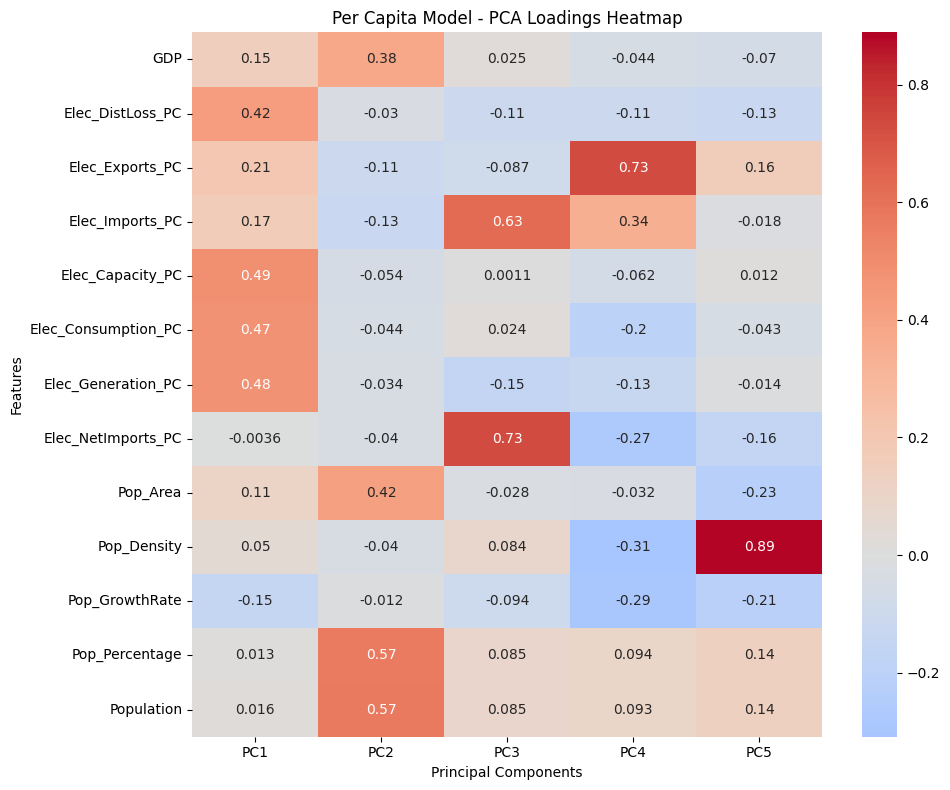

In [ ]:
# 10. Visualize the loadings
loadings_pc = pd.DataFrame(pca_gdp_model_per_capita.components_[:5], columns=features_per_capita)
loadings_pc = loadings_pc.T
loadings_pc.columns = [f'PC{i+1}' for i in range(loadings_pc.shape[1])]

feature_name_mapping = {
    'Economics: GDP': 'GDP',
    'Electricity: Distribution Losses Per Capita': 'Elec_DistLoss_PC',
    'Electricity: Exports Per Capita': 'Elec_Exports_PC',
    'Electricity: Imports Per Capita': 'Elec_Imports_PC',
    'Electricity: Installed Capacity Per Capita': 'Elec_Capacity_PC',
    'Electricity: Net Consumption Per Capita': 'Elec_Consumption_PC',
    'Electricity: Net Generation Per Capita': 'Elec_Generation_PC',
    'Electricity: Net Imports Per Capita': 'Elec_NetImports_PC',
    'Population: Area (km²)':'Pop_Area',
    'Population: Density': 'Pop_Density', 
    'Population: Growth Rate': 'Pop_GrowthRate',
    'Population: Percentage': 'Pop_Percentage',
    'Population: Population': 'Population',
}
loadings_pc.rename(index=feature_name_mapping, inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(loadings_pc, annot=True, cmap='coolwarm', center=0)
plt.title('GDP Per Capita Model - PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

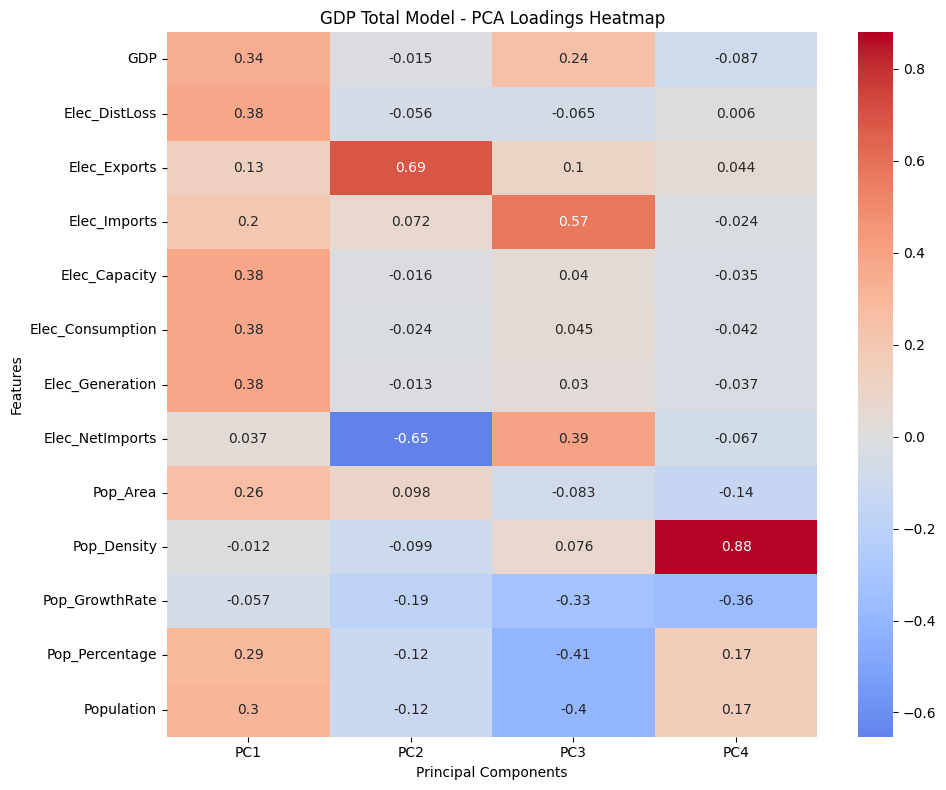

In [25]:
loadings_total = pd.DataFrame(pca_gdp_model_total.components_[:4], columns=features_total)
loadings_total = loadings_total.T
loadings_total.columns = [f'PC{i+1}' for i in range(loadings_total.shape[1])]

feature_name_mapping = {
    'Economics: GDP': 'GDP',
    'Electricity: Distribution Losses': 'Elec_DistLoss',
    'Electricity: Exports': 'Elec_Exports',
    'Electricity: Imports': 'Elec_Imports',
    'Electricity: Installed Capacity': 'Elec_Capacity',
    'Electricity: Net Consumption': 'Elec_Consumption',
    'Electricity: Net Generation': 'Elec_Generation',
    'Electricity: Net Imports': 'Elec_NetImports',
    'Population: Area (km²)':'Pop_Area',
    'Population: Density': 'Pop_Density', 
    'Population: Growth Rate': 'Pop_GrowthRate',
    'Population: Percentage': 'Pop_Percentage',
    'Population: Population': 'Population',
}
loadings_total.rename(index=feature_name_mapping, inplace=True)

# 2. 绘制热力图来展示载荷矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_total, annot=True, cmap='coolwarm', center=0)
plt.title('GDP Total Model - PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()